In [2]:
import pandas as pd # for data analytics
import numpy as np # for numerical computation
from matplotlib import pyplot as plt, style # for ploting
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix # for evaluation
import itertools

np.random.seed(42) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyed from a kernel by joparga3 https://www.kaggle.com/joparga3/kernels
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
dataset = pd.read_csv('./creditcard.csv')#.drop('Time', axis=1)

dataset['Amount'] = np.log(dataset['Amount'] + 1)
dataset['Time'] = np.log(dataset['Time'] + 1)
normal = dataset[dataset['Class'] == 0]

anomaly = dataset[dataset['Class'] == 1]
print(normal.shape)
print(anomaly.shape)

(284315, 31)
(492, 31)


In [4]:
from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.2, random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion os anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion os anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape:, ', test.shape)
print('Proportion os anomaly in test set: %.2f\n' % test['Class'].mean())

Train shape:  (227452, 31)
Proportion os anomaly in training set: 0.00

Valid shape:  (28677, 31)
Proportion os anomaly in validation set: 0.01

Test shape:,  (28678, 31)
Proportion os anomaly in test set: 0.01



/tmp/ipykernel_19389/2620657688.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
/tmp/ipykernel_19389/2620657688.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)


In [7]:
from scipy.stats import multivariate_normal

mu = train.drop('Class', axis=1).mean(axis=0).values
sigma = train.drop('Class', axis=1).cov().values
model = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)

print(np.median(model.logpdf(valid[valid['Class'] == 0].drop('Class', axis=1).values))) 
print(np.median(model.logpdf(valid[valid['Class'] == 1].drop('Class', axis=1).values))) 

-32.81908828871331
-661.9006173762164


In [8]:
tresholds = np.linspace(-1000,-10, 150)
scores = []
for treshold in tresholds:
    y_hat = (model.logpdf(valid.drop('Class', axis=1).values) < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(f'Precision score: {scores[:, 2].max()}\nPosicion: {scores[:, 2].argmax()}')

Precision score: 0.749395648670427
Posicion: 110


In [9]:
scores.shape

(150, 3)

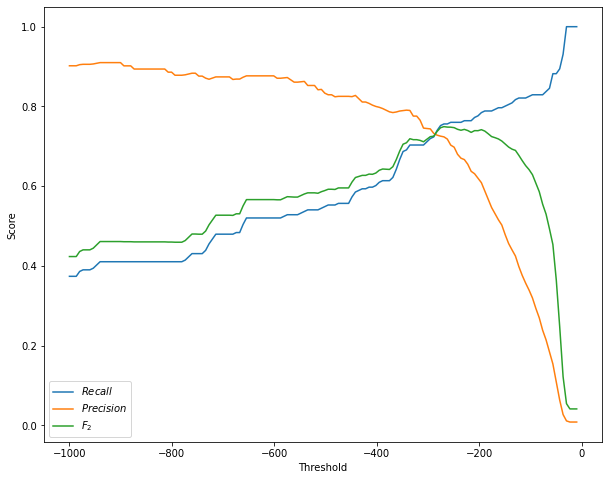

In [10]:
fig = plt.figure(figsize=(10,8))
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
# plt.xticks(np.logspace(-10, -200, 3))
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: -269
Test Recall Score: 0.793
Test Precision Score: 0.701
Test F2 Score: 0.773


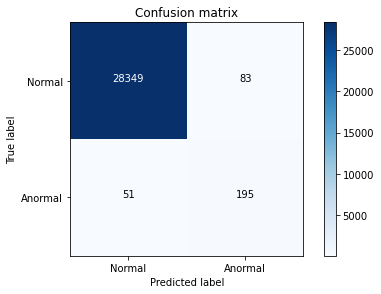

In [11]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.logpdf(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %d' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))


cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal']
                      , title='Confusion matrix')

# Histogram based 

/home/vcalzada/Work/proyecto/.proPy/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vcalzada/Work/proyecto/.proPy/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


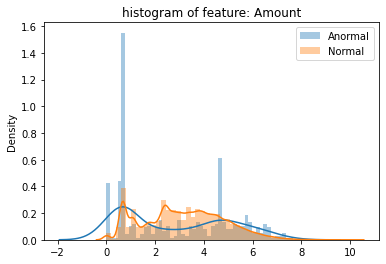

/home/vcalzada/Work/proyecto/.proPy/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vcalzada/Work/proyecto/.proPy/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


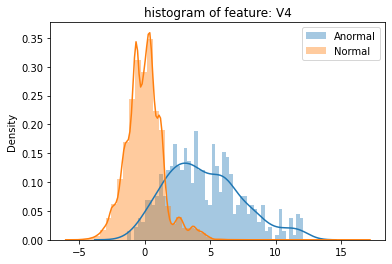

/home/vcalzada/Work/proyecto/.proPy/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vcalzada/Work/proyecto/.proPy/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


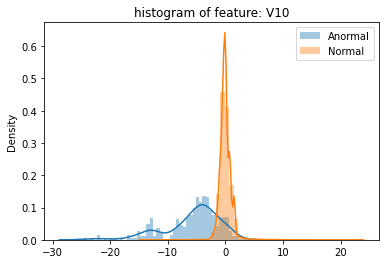

/home/vcalzada/Work/proyecto/.proPy/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vcalzada/Work/proyecto/.proPy/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


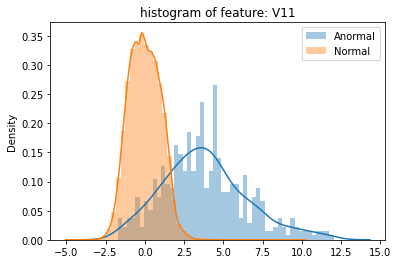

/home/vcalzada/Work/proyecto/.proPy/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/vcalzada/Work/proyecto/.proPy/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


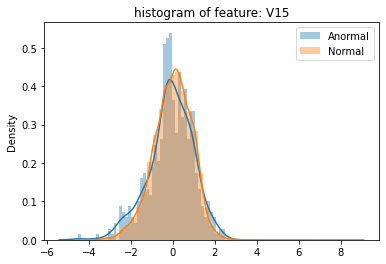

In [12]:
import matplotlib.gridspec as gridspec

# plt.figure(figsize=(12,28*5))
# gs = gridspec.GridSpec(28, 1)
for feature in ['Amount', 'V4', 'V10', 'V11', 'V15']:
    ax = plt.subplot()
    sns.distplot(dataset[feature][dataset.Class == 1], bins=50, label='Anormal')
    sns.distplot(dataset[feature][dataset.Class == 0], bins=50, label='Normal')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(feature))
    plt.legend(loc='best')
    plt.show()

In [13]:
class hist_model(object):
    
    def __init__(self, bins=50):
        self.bins = bins
        
    def fit(self, X):
        
        bin_hight, bin_edge = [], []
        
        for var in X.T:
            # get bins hight and interval
            bh, bedge = np.histogram(var, bins=self.bins)
            bin_hight.append(bh)
            bin_edge.append(bedge)
        
        self.bin_hight = np.array(bin_hight)
        self.bin_edge = np.array(bin_edge)
   

    def predict(self, X):
        
        scores = []
        for obs in X:
            obs_score = []
            for i, var in enumerate(obs):
                # find wich bin obs is in
                bin_num = (var > self.bin_edge[i]).argmin()-1
                obs_score.append(self.bin_hight[i, bin_num]) # find bin hitght
            
            scores.append(np.mean(obs_score))
        
        return np.array(scores)
                

        
model = hist_model()
model.fit(train.drop('Class', axis=1).values)
print(np.median(model.predict(valid[valid['Class'] == 0].drop('Class', axis=1).values))) 
print(np.median(model.predict(valid[valid['Class'] == 1].drop('Class', axis=1).values)))

67667.86666666667
30645.86666666667


In [14]:


tresholds = np.linspace(10000, 80000, 100)
scores = []
y_pred_score = model.predict(valid.drop('Class', axis=1).values)
for treshold in tresholds:
    y_hat = (y_pred_score < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)



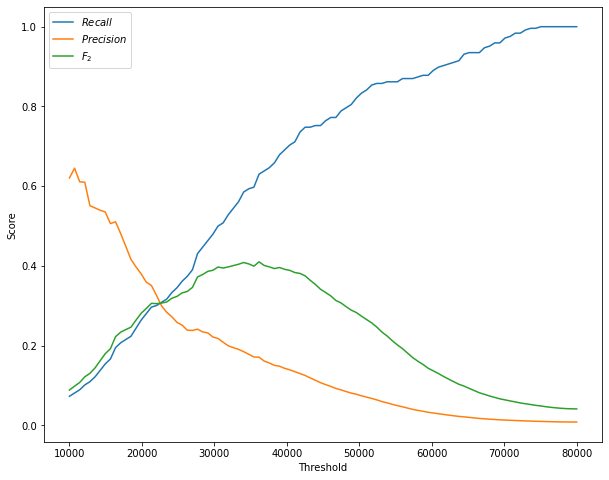

In [15]:
fig = plt.figure(figsize=(10,8))
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: 36161
Test Recall Score: 0.646
Test Precision Score: 0.170
Test F2 Score: 0.415


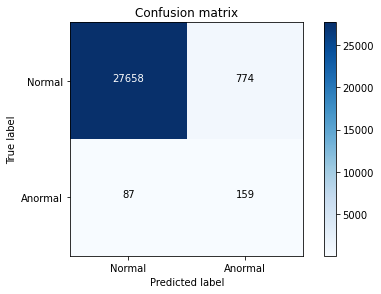

In [16]:


final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.predict(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %d' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')



# Cluster based technique 

In [17]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

gmm = BayesianGaussianMixture(n_components=3, n_init=4, random_state=42)
gmm.fit(train.drop('Class', axis=1).values)
print(gmm.score(valid[valid['Class'] == 0].drop('Class', axis=1).values))
print(gmm.score(valid[valid['Class'] == 1].drop('Class', axis=1).values))

2.859246638366292
-65110.56369523068


In [18]:


tresholds = np.linspace(-400, 0, 100)
y_scores = gmm.score_samples(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())



0.8004827031375704 74


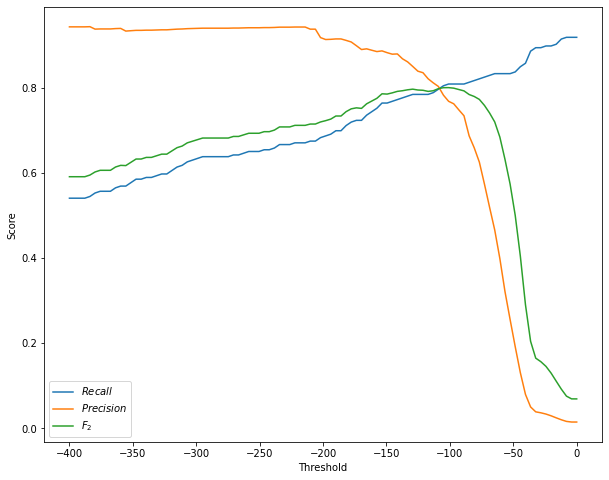

In [19]:
fig = plt.figure(figsize=(10,8))
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: -101.010101
Test Recall Score: 0.809
Test Precision Score: 0.737
Test F2 Score: 0.793


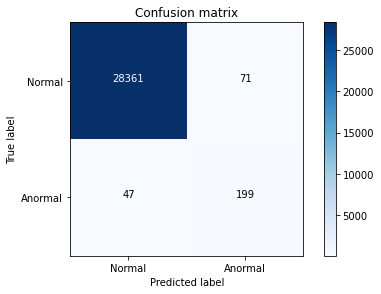

In [20]:


final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (gmm.score_samples(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')



# Novelty LOF

In [5]:
from sklearn.neighbors import LocalOutlierFactor
model = LocalOutlierFactor(n_neighbors=100,n_jobs=4,novelty=True)
model.fit(train.drop('Class', axis=1).values)

LocalOutlierFactor(n_jobs=4, n_neighbors=100, novelty=True)

In [6]:
print(model.decision_function(valid[valid['Class'] == 0].drop('Class', axis=1).values).mean())
print(model.decision_function(valid[valid['Class'] == 1].drop('Class', axis=1).values).mean())

0.37430987766020823
-1.4881208478150145


In [8]:
tresholds = np.linspace(-3, 2, 200)
y_scores = model.decision_function(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.7632013201320133 91


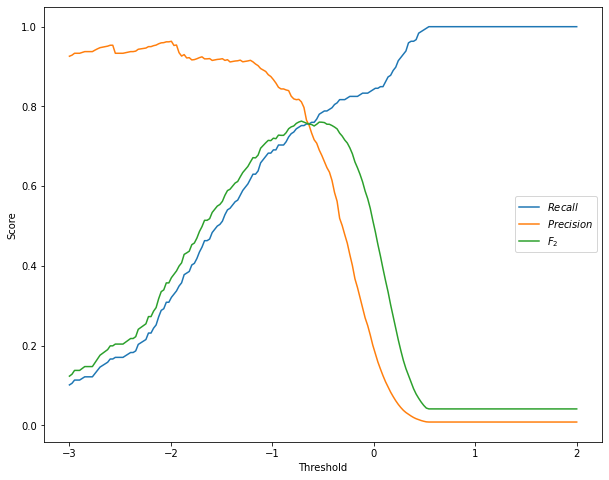

In [9]:
fig = plt.figure(figsize=(10,8))
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: -0.713568
Test Recall Score: 1.000
Test Precision Score: 0.009
Test F2 Score: 0.041


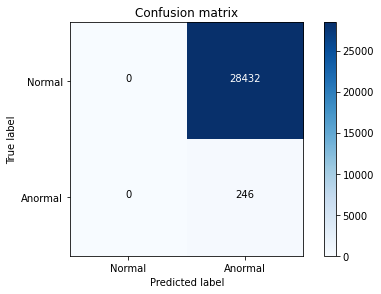

In [11]:


final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.score_samples(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')



In [12]:
from sklearn.metrics import classification_report
print(classification_report(test['Class'].values, y_hat_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     28432
           1       0.01      1.00      0.02       246

    accuracy                           0.01     28678
   macro avg       0.00      0.50      0.01     28678
weighted avg       0.00      0.01      0.00     28678



/home/vcalzada/Work/proyecto/.proPy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vcalzada/Work/proyecto/.proPy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vcalzada/Work/proyecto/.proPy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

# One Class SVM 

In [4]:
from sklearn.svm import OneClassSVM
np.random.seed(42)

model = OneClassSVM(gamma=0.000562, nu=.95, kernel='rbf')
model.fit(train.drop('Class', axis=1).values)
print(model.decision_function(valid[valid['Class'] == 0].drop('Class', axis=1).values).mean())
print(model.decision_function(valid[valid['Class'] == 1].drop('Class', axis=1).values).mean())

-2485.552110954542
-56372.96470386428


In [5]:
tresholds = np.linspace(-50000, -400, 500)
y_scores = model.decision_function(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.5264945652173914 277


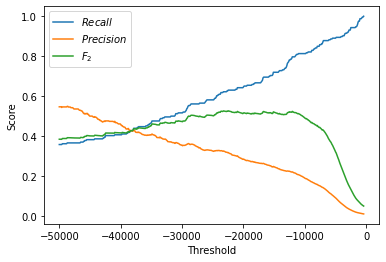

In [6]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [7]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.decision_function(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

Final threshold: -22466.533066
Test Recall Score: 0.630
Test Precision Score: 0.323
Test F2 Score: 0.529
